#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션3

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 딥러닝 구조의 모델로 분류 모델 생성
    * 최소 4개 이상 모델링 수행
    * (옵션) 각 모델별 최소 5회 반복수행해서 얻은 성능의 평균으로 비교
    * (옵션) 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.
* 성능 가이드
    * Accuracy : 0.90 ~ 0.99

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input
from keras.backend import clear_session
from keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.regularizers import l1
from sklearn.ensemble import RandomForestClassifier

In [26]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [27]:
data01_train = pd.read_csv(path + 'data01_train.csv')
data01_test = pd.read_csv(path + 'data01_test.csv')
features = pd.read_csv(path + 'features.csv')

In [28]:
data01_train.drop(columns = 'subject', inplace = True)
data01_test.drop(columns = 'subject', inplace =  True)

#### 2) 기본 정보 조회

In [29]:
data01_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [30]:
data01_train.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [31]:
data01_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB


In [32]:
features.head()

,sensor,agg,axis,feature_name
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z
3,tBodyAcc,std(),X,tBodyAcc-std()-X
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y


In [33]:
features.describe()

,sensor,agg,axis,feature_name
count,561,561,436,561
unique,18,27,62,561
top,fBodyGyro,bandsEnergy(),X,tBodyAcc-mean()-X
freq,79,126,76,1


In [34]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   sensor        561 non-null    object
 1   agg           561 non-null    object
 2   axis          436 non-null    object
 3   feature_name  561 non-null    object
dtypes: object(4)
memory usage: 17.7+ KB


## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다.


### (1) Y 전처리
* integer encoding : LabelEncoder
* (필요시) one-hot encoding

In [35]:
# Y 정수 인코딩
data01_train['Activity'] = LabelEncoder().fit_transform(data01_train['Activity'])
data01_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,2
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,2
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,3
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,4


In [36]:
# 타겟타입 확인
data01_train['Activity'].dtype

dtype('int64')

### (2) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [37]:
# 타겟 설정
target = 'Activity'

# x, y 분할
x = data01_train.drop(columns = target)
y = data01_train.loc[:, target]

### (3) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [38]:
# train, validation 데이터 분할
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 1)

### (4) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

- MinMaxScaler 사용한 이유 : 비선형 모델을 사용 / 원래 분포를 유지한 상태에서 범위를 변경

In [39]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

## **3. 기본 모델링**



* 세부 요구사항
    - 모델1 : Base line 모델
        * Hidden Layer 없이 모델 생성
    - 모델2 : 복잡한 모델 생성
        * 최소 5개 이상의 은닉층을 추가한 모델
    - 모델3 ~ n : 튜닝 모델
        * 학습률, epoch 등 조정
        * 모델2에 과적합을 방지하기 위한 규제 기법 추가
        * Accuracy 최대화 시키는 모델 생성하기 (recall, precision 등 같이 보기)
    - 각 모델은 최소 5번 반복수행해서 얻은 성능의 평균값을 기록

In [40]:
# nfeatures 선언
nfeatures = x_train.shape[1]
nfeatures

561

### (1) 모델1 : 히든레이어 5개 + lr 0.01

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
모델1 - 반복 1: 정확도 = 0.8309


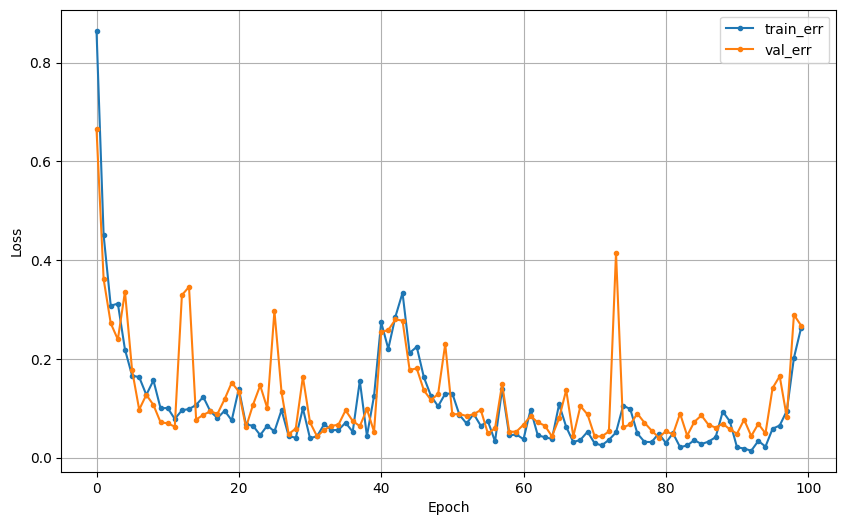

0.8309260832625318
[[222   0   0   0   0   0]
 [  0 187  11   0   0   0]
 [  0   9 226   0   0   0]
 [  0   0   0 192   0   0]
 [  0   0   0   4 151   1]
 [  0   0   0   0 174   0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       222
           1       0.95      0.94      0.95       198
           2       0.95      0.96      0.96       235
           3       0.98      1.00      0.99       192
           4       0.46      0.97      0.63       156
           5       0.00      0.00      0.00       174

    accuracy                           0.83      1177
   macro avg       0.73      0.81      0.75      1177
weighted avg       0.76      0.83      0.78      1177


모델1의 최종 평균 정확도 (1번 반복): 0.8309

모델1의 최종 편차 정확도 (1번 반복): 0.0000



In [41]:
n_repeats = 5
accuracies_model1 = []
results_list = []

for repeat in range(n_repeats):
    model1 = Sequential([Input(shape=(nfeatures,)),
                         Dense(128, activation = 'relu'),
                         Dense(64, activation = 'relu'),
                         Dense(32, activation = 'relu'),
                         Dense(16, activation = 'relu'),
                         Dense(8, activation = 'relu'),
                         Dense(6, activation = 'softmax')])

    model1.compile(optimizer=Adam(0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    result1 = model1.fit(x_train, y_train, epochs=100, validation_split=0.2, verbose=0).history

    pred1 = model1.predict(x_val)
    pred1 = pred1.argmax(axis=1)

    report = classification_report(y_val, pred1, output_dict=True)
    accuracy = report['accuracy']
    accuracies_model1.append(accuracy)
    print(f'모델1 - 반복 {repeat + 1}: 정확도 = {accuracy:.4f}')

    results_list.append({
        'model': 'Model 1',
        'repeat': repeat + 1,
        'accuracy': accuracy
    })
    dl_history_plot(result1)

    print(accuracy_score(y_val, pred1))
    print(confusion_matrix(y_val, pred1))
    print(classification_report(y_val, pred1))

average_accuracy_model1 = np.mean(accuracies_model1)
std_accuracy_model1 = np.std(accuracies_model1)
print('')
print(f'모델1의 최종 평균 정확도 ({n_repeats}번 반복): {average_accuracy_model1:.4f}\n')
print(f'모델1의 최종 편차 정확도 ({n_repeats}번 반복): {std_accuracy_model1:.4f}\n')

### (2) 모델2 : 히든레이어 5개 + 드롭아웃 + lr 0.001

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
모델2 - 반복 1: 정확도 = 0.9822


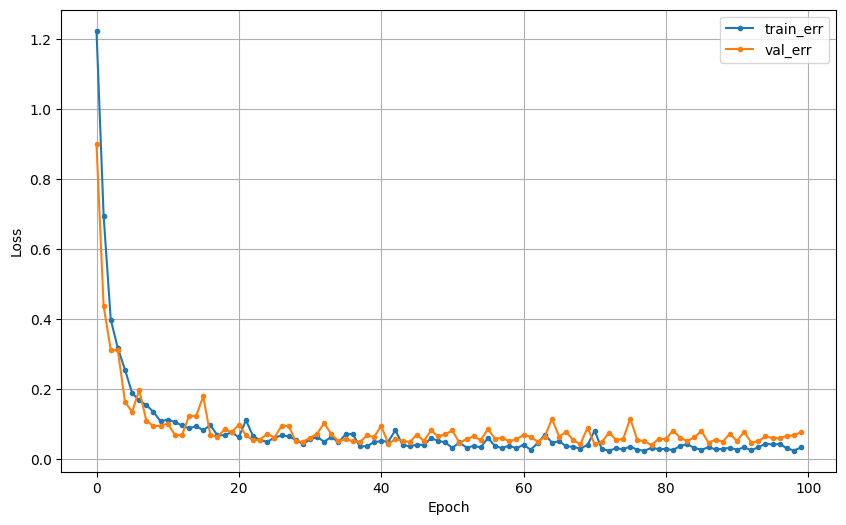

0.9821580288870009
[[222   0   0   0   0   0]
 [  0 195   3   0   0   0]
 [  0  16 219   0   0   0]
 [  0   0   0 190   2   0]
 [  0   0   0   0 156   0]
 [  0   0   0   0   0 174]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       222
           1       0.92      0.98      0.95       198
           2       0.99      0.93      0.96       235
           3       1.00      0.99      0.99       192
           4       0.99      1.00      0.99       156
           5       1.00      1.00      1.00       174

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177


모델2의 최종 평균 정확도 (1번 반복): 0.9822

모델2의 최종 편차 정확도 (1번 반복): 0.0000



In [42]:
n_repeats = 5
accuracies_model2 = []
results_list = []

for repeat in range(n_repeats):
    model2 = Sequential([Input(shape=(nfeatures,)),
                         Dense(128, activation = 'relu'),
			                   Dropout(0.2),
                         Dense(64, activation = 'relu'),
                         Dense(32, activation = 'relu'),
                         Dense(16, activation = 'relu'),
                         Dense(8, activation = 'relu'),
                         Dense(6, activation = 'softmax')])

    model2.compile(optimizer=Adam(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    result2 = model2.fit(x_train, y_train, epochs=100, validation_split=0.2, verbose=0).history

    pred2 = model2.predict(x_val)
    pred2 = pred2.argmax(axis=1)

    report = classification_report(y_val, pred2, output_dict=True)
    accuracy = report['accuracy']
    accuracies_model2.append(accuracy)
    print(f'모델2 - 반복 {repeat + 1}: 정확도 = {accuracy:.4f}')

    results_list.append({
        'model': 'Model 2',
        'repeat': repeat + 1,
        'accuracy': accuracy
    })
    dl_history_plot(result2)

    print(accuracy_score(y_val, pred2))
    print(confusion_matrix(y_val, pred2))
    print(classification_report(y_val, pred2))

average_accuracy_model2 = np.mean(accuracies_model2)
std_accuracy_model2 = np.std(accuracies_model2)
print('')
print(f'모델2의 최종 평균 정확도 ({n_repeats}번 반복): {average_accuracy_model2:.4f}\n')
print(f'모델2의 최종 편차 정확도 ({n_repeats}번 반복): {std_accuracy_model2:.4f}\n')

### (3) 모델3 : 히든레이어 6개 + 드롭아웃 + lr 0.001

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
모델3 - 반복 1: 정확도 = 0.9745


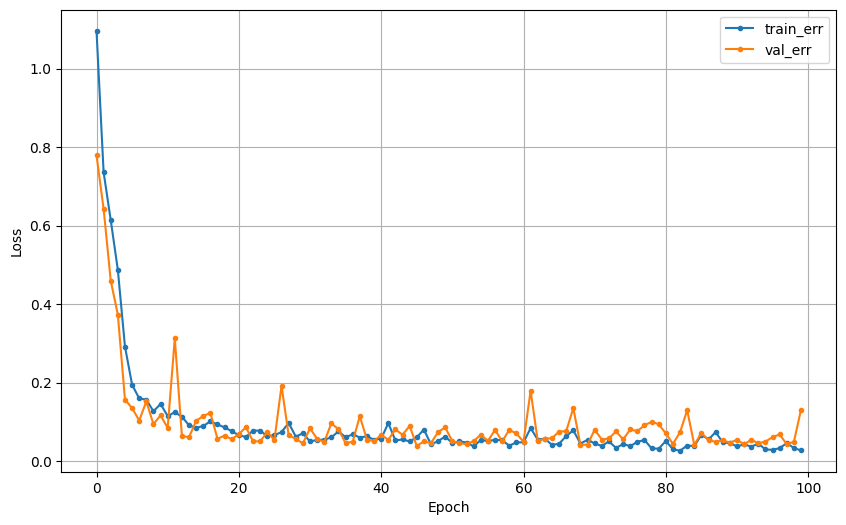

0.9745114698385726
[[222   0   0   0   0   0]
 [  1 187  10   0   0   0]
 [  0   6 229   0   0   0]
 [  0   0   0 192   0   0]
 [  0   0   0   6 150   0]
 [  0   0   0   7   0 167]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       222
           1       0.97      0.94      0.96       198
           2       0.96      0.97      0.97       235
           3       0.94      1.00      0.97       192
           4       1.00      0.96      0.98       156
           5       1.00      0.96      0.98       174

    accuracy                           0.97      1177
   macro avg       0.98      0.97      0.97      1177
weighted avg       0.98      0.97      0.97      1177


모델3의 최종 평균 정확도 (1번 반복): 0.9745

모델3의 최종 편차 정확도 (1번 반복): 0.0000



In [43]:
n_repeats = 5
accuracies_model3 = []
results_list = []

for repeat in range(n_repeats):
    model3 = Sequential([Input(shape=(nfeatures,)),
                     Dense(256, activation = 'relu'),
                     Dropout(0.2),
                     Dense(128, activation = 'relu'),
                     Dropout(0.2),
                     Dense(64, activation = 'relu'),
                     Dense(32, activation = 'relu'),
                     Dense(16, activation = 'relu'),
                     Dense(8, activation = 'relu'),
                     Dense(6, activation = 'softmax')])

    model3.compile(optimizer=Adam(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    result3 = model3.fit(x_train, y_train, epochs=100, validation_split=0.2, verbose=0).history

    pred3 = model3.predict(x_val)
    pred3 = pred3.argmax(axis=1)

    report = classification_report(y_val, pred3, output_dict=True)
    accuracy = report['accuracy']
    accuracies_model3.append(accuracy)
    print(f'모델3 - 반복 {repeat + 1}: 정확도 = {accuracy:.4f}')

    results_list.append({
        'model': 'Model 3',
        'repeat': repeat + 1,
        'accuracy': accuracy
    })
    dl_history_plot(result3)

    print(accuracy_score(y_val, pred3))
    print(confusion_matrix(y_val, pred3))
    print(classification_report(y_val, pred3))

average_accuracy_model3 = np.mean(accuracies_model3)
std_accuracy_model3 = np.std(accuracies_model3)
print('')
print(f'모델3의 최종 평균 정확도 ({n_repeats}번 반복): {average_accuracy_model3:.4f}\n')
print(f'모델3의 최종 편차 정확도 ({n_repeats}번 반복): {std_accuracy_model3:.4f}\n')

### (4) 모델4 : 히든레이어 5개 + l1설정 + 드롭아웃 + lr 0.001

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
모델4: 복잡한 모델 - 반복 1: 정확도 = 0.9754


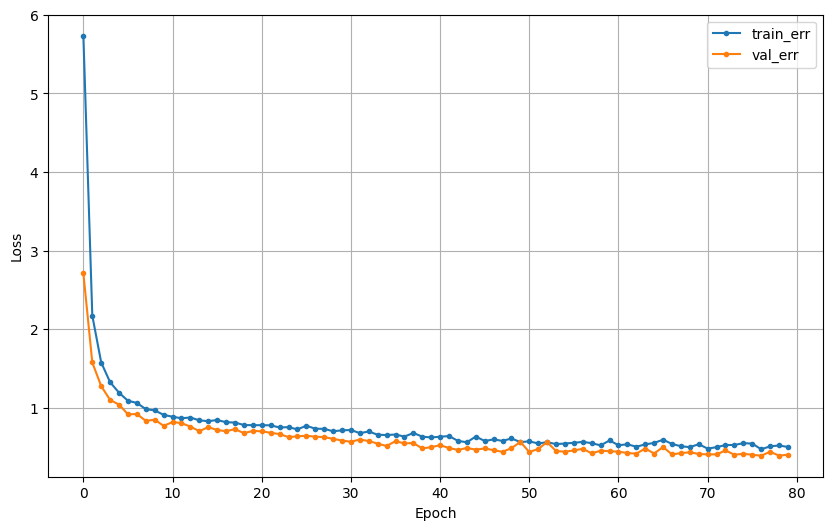

0.9753610875106202
[[222   0   0   0   0   0]
 [  0 192   6   0   0   0]
 [  0  19 216   0   0   0]
 [  0   0   0 192   0   0]
 [  0   0   0   2 154   0]
 [  0   0   0   2   0 172]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       222
           1       0.91      0.97      0.94       198
           2       0.97      0.92      0.95       235
           3       0.98      1.00      0.99       192
           4       1.00      0.99      0.99       156
           5       1.00      0.99      0.99       174

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177


모델4의 최종 평균 정확도 (1번 반복): 0.9754

모델4의 최종 편차 정확도 (1번 반복): 0.0000



In [44]:
n_repeats = 5
accuracies_model4 = []
results_list = []

for repeat in range(n_repeats):
    model4 = Sequential([Input(shape=(nfeatures,)),
                     Dense(256,activation='relu',
                         kernel_regularizer= l1(0.001)),
                     Dropout(0.2),
                     Dense(128,activation='relu',
                         kernel_regularizer= l1(0.001)),
                     Dropout(0.2),
                     Dense(64,activation='relu',
                         kernel_regularizer= l1(0.001)),
                     Dropout(0.2),
                     Dense(32,activation='relu',
                         kernel_regularizer= l1(0.001)),
                     Dropout(0.2),
                     Dense(16,activation='relu',
                         kernel_regularizer= l1(0.001)),
                     Dropout(0.2),
                     Dense(6,activation = 'softmax')])

    model4.compile(optimizer=Adam(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    result4 = model4.fit(x_train, y_train, epochs=80, verbose=0, validation_split=0.2).history

    pred4 = model4.predict(x_val)
    pred4 = pred4.argmax(axis=1)

    report = classification_report(y_val, pred4, output_dict=True)
    accuracy = report['accuracy']
    accuracies_model4.append(accuracy)
    print(f'모델4: 복잡한 모델 - 반복 {repeat + 1}: 정확도 = {accuracy:.4f}')

    results_list.append({
        'model': 'Model 4',
        'repeat': repeat + 1,
        'accuracy': accuracy
    })
    dl_history_plot(result4)
    print(accuracy_score(y_val, pred4))
    print(confusion_matrix(y_val, pred4))
    print(classification_report(y_val, pred4))

average_accuracy_model4 = np.mean(accuracies_model4)
std_accuracy_model4 = np.std(accuracies_model4)
print('')
print(f'모델4의 최종 평균 정확도 ({n_repeats}번 반복): {average_accuracy_model4:.4f}\n')
print(f'모델4의 최종 편차 정확도 ({n_repeats}번 반복): {std_accuracy_model4:.4f}\n')

### (5) 모델5 : 히든레이어 4개 + 드롭아웃 + lr 0.002

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
모델4: 복잡한 모델 - 반복 1: 정확도 = 0.9754


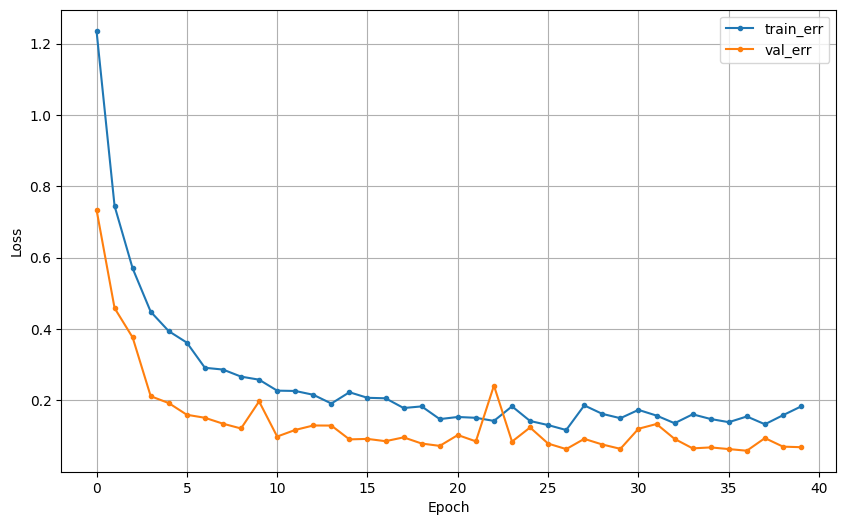

0.9753610875106202
[[222   0   0   0   0   0]
 [  0 188  10   0   0   0]
 [  0  11 224   0   0   0]
 [  0   0   0 192   0   0]
 [  0   0   0   1 155   0]
 [  0   0   0   3   4 167]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       222
           1       0.94      0.95      0.95       198
           2       0.96      0.95      0.96       235
           3       0.98      1.00      0.99       192
           4       0.97      0.99      0.98       156
           5       1.00      0.96      0.98       174

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177


모델5의 최종 평균 정확도 (1번 반복): 0.9754

모델5의 최종 편차 정확도 (1번 반복): 0.0000



In [45]:
n_repeats = 5
accuracies_model5 = []
results_list = []

for repeat in range(n_repeats):
    model5 = Sequential([Input (shape = (nfeatures, )),
                        Dense(114,activation='relu'),
                        Dropout(0.2),
                        Dense(58,activation='relu'),
                        Dropout(0.2),
                        Dense(24,activation='relu'),
                        Dropout(0.2),
                        Dense(12,activation='relu'),
                        Dropout(0.2),
                        Dense(6, activation= 'softmax')])

    model5.compile(optimizer=Adam(learning_rate=0.002), loss='sparse_categorical_crossentropy')
    result5 = model5.fit(x_train, y_train, epochs=40, validation_split=0.2, verbose=0).history

    pred5 = model5.predict(x_val)
    pred5 = pred5.argmax(axis=1)

    report = classification_report(y_val, pred4, output_dict=True)
    accuracy = report['accuracy']
    accuracies_model5.append(accuracy)
    print(f'모델4: 복잡한 모델 - 반복 {repeat + 1}: 정확도 = {accuracy:.4f}')

    results_list.append({
        'model': 'Model 5',
        'repeat': repeat + 1,
        'accuracy': accuracy
    })
    dl_history_plot(result5)
    print(accuracy_score(y_val, pred5))
    print(confusion_matrix(y_val, pred5))
    print(classification_report(y_val, pred5))

average_accuracy_model5 = np.mean(accuracies_model5)
std_accuracy_model5 = np.std(accuracies_model5)
print('')
print(f'모델5의 최종 평균 정확도 ({n_repeats}번 반복): {average_accuracy_model5:.4f}\n')
print(f'모델5의 최종 편차 정확도 ({n_repeats}번 반복): {std_accuracy_model5:.4f}\n')

### (6) 모델6 : 랜덤포레스트로 추출한 변수 중요도가 0.001 이상인 것만 feature

In [46]:
# 불러오기
data01_train_2 = pd.read_csv(path + 'data01_train.csv')
data01_train_2.drop(columns = 'subject', inplace = True)

In [47]:
# 0, 1로 전처리
data01_train_2['is_dynamic'] = np.where(np.isin(data01_train_2['Activity'], ['STANDING', 'SITTING', 'LAYING']), 0, 1)
data01_train_2 = data01_train_2.drop("Activity",axis= 1)
data01_train_2.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",is_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,1


In [48]:
# x, y 나누기
target = 'is_dynamic'

x = data01_train_2.drop(target,axis=1)
y = data01_train_2.loc[:,target]
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=1)

In [49]:
# 변수 중요도에 따른 데이터셋 생성
model_importances = RandomForestClassifier()
model_importances.fit(x_train, y_train)

importances = model_importances.feature_importances_

# 변수 중요도를 데이터프레임으로 변환
importance_df = pd.DataFrame({'feature': x.columns, 'importance': importances})

# 중요도가  이상인 변수 필터링
filtered_features = importance_df[importance_df['importance'] >= 0.001]['feature'].tolist()

# 필터링된 특성으로 새로운 데이터셋 생성
x_train = x_train[filtered_features]
x_val = x_val[filtered_features]

print(filtered_features)
len(filtered_features)

['tBodyAcc-mad()-X', 'tBodyAcc-max()-X', 'tBodyAccJerk-std()-X', 'tBodyAccJerk-std()-Y', 'tBodyAccJerk-mad()-X', 'tBodyAccJerk-sma()', 'tBodyAccJerk-energy()-X', 'tBodyAccJerk-energy()-Y', 'tBodyAccJerk-iqr()-X', 'tBodyAccJerk-iqr()-Y', 'tBodyAccJerk-entropy()-X', 'tBodyAccJerk-entropy()-Z', 'tBodyGyro-std()-Y', 'tBodyGyro-iqr()-Y', 'tBodyGyroJerk-mad()-Z', 'tBodyGyroJerk-sma()', 'tBodyGyroJerk-iqr()-Z', 'tBodyGyroJerk-entropy()-Z', 'tBodyAccJerkMag-mean()', 'tBodyAccJerkMag-std()', 'tBodyAccJerkMag-mad()', 'tBodyAccJerkMag-sma()', 'tBodyAccJerkMag-energy()', 'tBodyAccJerkMag-iqr()', 'tBodyAccJerkMag-entropy()', 'tBodyGyroJerkMag-sma()', 'fBodyAcc-mean()-X', 'fBodyAcc-mad()-X', 'fBodyAcc-sma()', 'fBodyAcc-entropy()-X', 'fBodyAcc-bandsEnergy()-9,16', 'fBodyAcc-bandsEnergy()-1,24', 'fBodyAccJerk-std()-X', 'fBodyAccJerk-mad()-X', 'fBodyAccJerk-max()-X', 'fBodyAccJerk-max()-Y', 'fBodyAccJerk-energy()-X', 'fBodyAccJerk-energy()-Y', 'fBodyAccJerk-entropy()-Y', 'fBodyAccJerk-bandsEnergy()-1,8

50

In [50]:
nfeatures = x_train.shape[1]
nfeatures

50

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
                    0           1  accuracy    macro avg  weighted avg
precision    0.998471    0.996176  0.997451     0.997323      0.997453
recall       0.996947    0.998084  0.997451     0.997515      0.997451
f1-score     0.997708    0.997129  0.997451     0.997419      0.997451
support    655.000000  522.000000  0.997451  1177.000000   1177.000000
모델6: 정확도 = 0.9975
ROC AUC Score : 1.0000


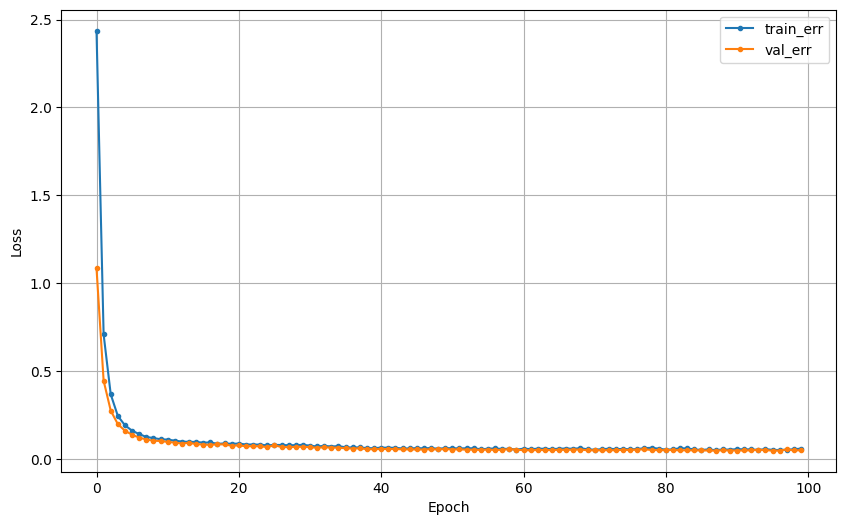

In [51]:
clear_session()

model6 = Sequential([Input(shape=(nfeatures,)),
                     Dense(256,activation='relu',
                         kernel_regularizer= l1(0.001)),
                     Dropout(0.2),
                     Dense(128,activation='relu',
                         kernel_regularizer= l1(0.001)),
                     Dropout(0.2),
                     Dense(64,activation='relu',
                         kernel_regularizer= l1(0.001)),
                     Dropout(0.2),
                     Dense(32,activation='relu',
                         kernel_regularizer= l1(0.001)),
                     Dropout(0.2),
                     Dense(16,activation='relu',
                         kernel_regularizer= l1(0.001)),
                     Dropout(0.2),
                     Dense(1,activation = 'sigmoid')])
# 모델 컴파일
model6.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

# 모델 훈련
result6 = model6.fit(x_train, y_train, epochs=100, verbose=0, validation_split=0.2).history

# 예측 확률
pred6_proba = model6.predict(x_val)  # 확률을 예측
pred6 = np.where(pred6_proba >= 0.5, 1, 0)  # 예측된 클래스의 인덱스를 선택

# 평가
report = classification_report(y_val, pred6, output_dict=True)
print(pd.DataFrame(report))
accuracy = report['accuracy']
print(f'모델6: 정확도 = {accuracy:.4f}')

# AUC 값 계산
roc_auc = roc_auc_score(y_val, pred6_proba)  # 예측 확률을 사용
print(f"ROC AUC Score : {roc_auc:.4f}")

dl_history_plot(result6)

## 4.성능비교

* 세부 요구사항
    - test 데이터에 대한 전처리
    - 각 모델에 대해서 test 데이터로 성능 측정

In [52]:
# test 데이터 확인
data01_test.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.509523,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.210792,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.579587,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.566291,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.447577,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING


In [53]:
# test 데이터 전처리
target = "Activity"

x_test= data01_test.drop(target,axis=1)
y_test= data01_test.loc[:,target]

encoder= LabelEncoder()
y_tested = encoder.fit_transform(y_test)

scaler = MinMaxScaler()
x_tested= scaler.fit_transform(x_test)

In [54]:
# 모델 예측 결과를 저장할 리스트 초기화
y_pred_all = []

# 각 모델(1~5)에 대한 예측 수행
for model in [model1, model2, model3, model4, model5]:
    y_pred_test = model.predict(x_tested)
    y_pred_test = y_pred_test.argmax(axis=1)
    y_pred_all.append(y_pred_test)

# 정확도를 저장할 리스트 초기화
accuracies = []

# 각 모델(1~5)의 정확도 계산
for i in range(len(y_pred_all)):
    accuracy = accuracy_score(y_tested, y_pred_all[i])
    accuracies.append(accuracy)
    print(f'Model {i + 1} Accuracy: {accuracy:.4f}')

# 각 모델(1~5) 정확도 출력
print("\nAll Models Accuracy:")
for i, accuracy in enumerate(accuracies):
    print(f'Model {i + 1}: {accuracy:.4f}')

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Model 1 Accuracy: 0.8185
Model 2 Accuracy: 0.9721
Model 3 Accuracy: 0.9341
Model 4 Accuracy: 0.9646
Model 5 Accuracy: 0.9551

All Models Accuracy:
Model 1: 0.8185
Model 2: 0.9721
Model 3: 0.9341
Model 4: 0.9646
Model 5: 0.9551


In [57]:
# 함수 정의
def binpipeline(test):
    # 'is_dynamic' 열 생성
    test['is_dynamic'] = np.where(np.isin(test['Activity'], ['STANDING', 'SITTING', 'LAYING']), 0, 1)

    # 'Activity' 열 제거
    test = test.drop("Activity", axis=1)

    # 타겟과 특성 데이터 분리
    target = "is_dynamic"
    x_test = test.drop(target, axis=1)
    y_test = test[target]

    x_test_filtered = x_test[filtered_features]

    # y_test는 필터링하지 않음 (타겟 값 유지)
    return x_test_filtered, y_test

test = pd.read_csv(path + 'data01_test.csv')

# 필터링된 데이터셋 생성
x_test_filtered, y_test = binpipeline(test)
print(x_test_filtered.shape)  # 입력 데이터 크기 확인

(1471, 50)


In [61]:
# 1. Test 데이터에 대해 예측 수행
pred_test_proba = model6.predict(x_test_filtered)  # 테스트 데이터에 대한 확률 예측
pred_test = np.where(pred_test_proba >= 0.5, 1, 0)  # 임계값 0.5로 이진 분류

# 2. 분류 보고서 출력
test_report = classification_report(y_test, pred_test, output_dict=True)
cm = confusion_matrix(y_test,pred_test)
print(cm)
print(pd.DataFrame(test_report))

# 3. 정확도 출력
test_accuracy = test_report['accuracy']
print(f'테스트 데이터 정확도 = {test_accuracy:.4f}')

# 4. 정확도 리스트에 입력
accuracy = accuracy_score(y_test, pred_test)
accuracies.append(accuracy)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[[833   0]
 [  1 637]]
                    0           1  accuracy    macro avg  weighted avg
precision    0.998801    1.000000   0.99932     0.999400      0.999321
recall       1.000000    0.998433   0.99932     0.999216      0.999320
f1-score     0.999400    0.999216   0.99932     0.999308      0.999320
support    833.000000  638.000000   0.99932  1471.000000   1471.000000
테스트 데이터 정확도 = 0.9993


In [62]:
# 결과 확인
# 정확도를 데이터프레임으로 변환
accuracy_df = pd.DataFrame({
    'Model': [f'Model {i + 1}' for i in range(len(accuracies))],
    'Accuracy': accuracies
})

accuracy_df = accuracy_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
display(accuracy_df)

,Model,Accuracy
0,Model 6,0.999320
1,Model 2,0.972128
2,Model 4,0.964650
3,Model 5,0.955133
4,Model 3,0.934058
5,Model 1,0.818491
